## read data from files netatmo

In [49]:
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

In [58]:
# supprimer d'abord les deux lignes dans le fichier d'export Neatatmo 
data1=pd.read_csv('data/Netatmo/CapteurAmbiance1_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col="Timestamp")
data2=pd.read_csv('data/Netatmo/CapteurAmbiance2_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col="Timestamp")
data3=pd.read_csv('data/Netatmo/CapteurAmbiance3_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col="Timestamp")
data4=pd.read_csv('data/Netatmo/CapteurAmbiance4_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col="Timestamp" )
#Linky=pd.read_csv('data/Netatmo/Enedis_Conso_DemiHeure_20210401-20220228.csv', sep=";", encoding = "ISO-8859-1")


In [59]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25994 entries, 1625090430 to 1633038868
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Timezone : Europe/Paris  25994 non-null  datetime64[ns]
 1   Temperature              25994 non-null  float64       
 2   Humidity                 25994 non-null  int64         
 3   CO2                      25994 non-null  int64         
 4   Noise                    25994 non-null  int64         
 5   Pressure                 25994 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.4 MB


In [60]:
data= pd.concat([data1, data2, data3, data4], axis=0)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94978 entries, 1617228022 to 1646088954
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Timezone : Europe/Paris  94978 non-null  datetime64[ns]
 1   Temperature              94978 non-null  float64       
 2   Humidity                 94978 non-null  int64         
 3   CO2                      94974 non-null  float64       
 4   Noise                    94974 non-null  float64       
 5   Pressure                 94978 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 5.1 MB


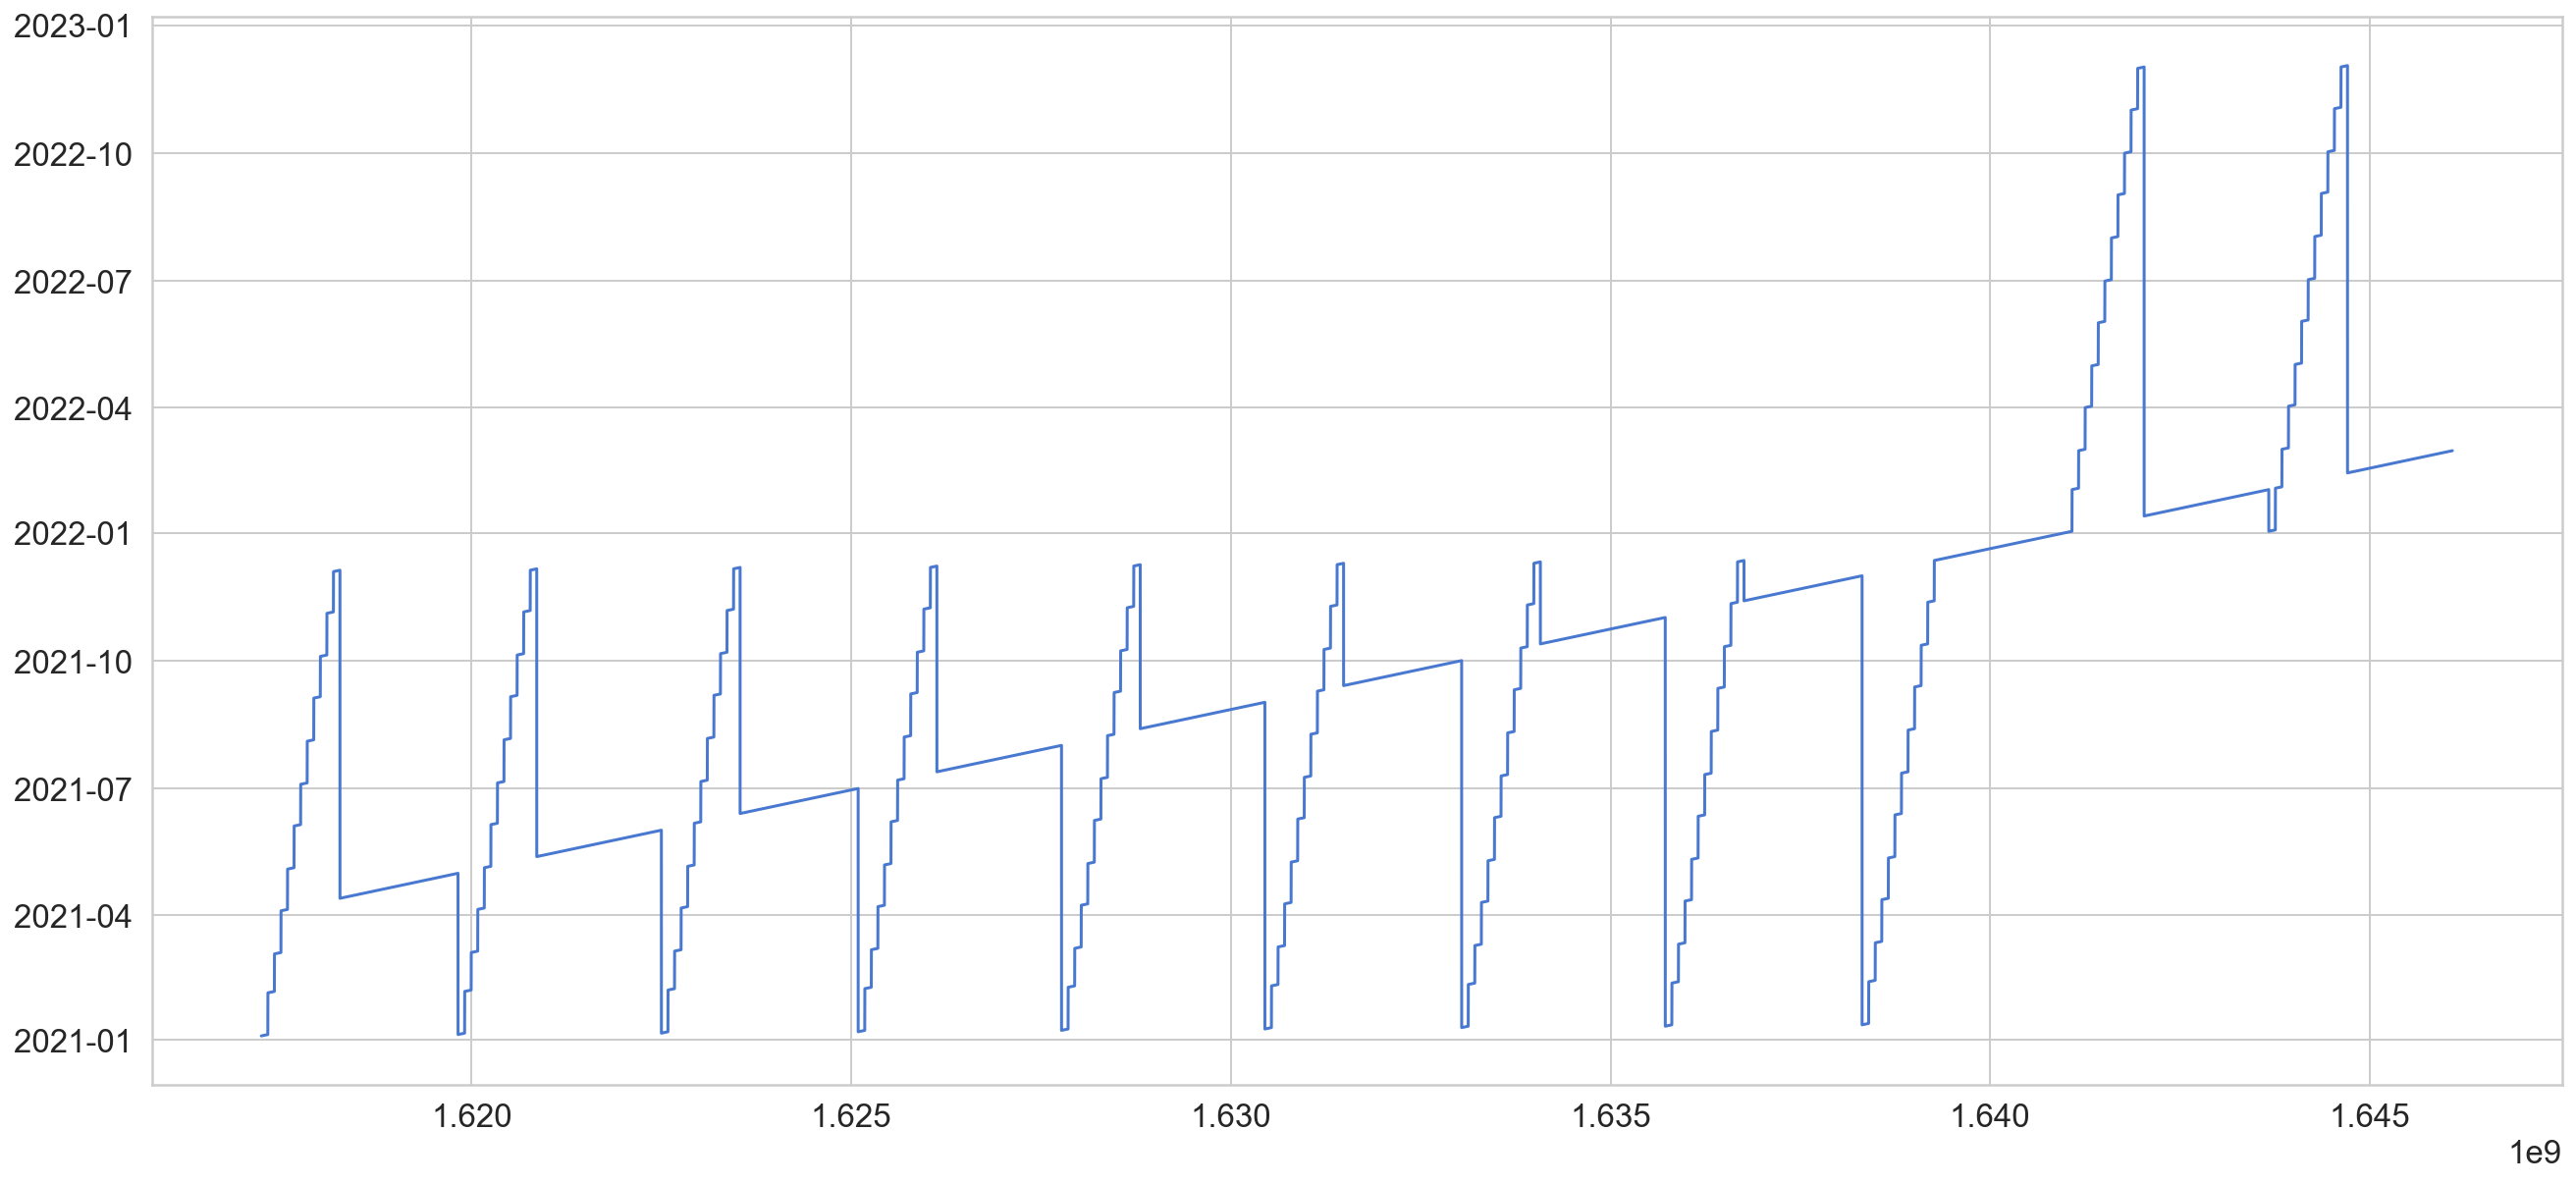

In [65]:
plt.plot(data["Timezone : Europe/Paris"])

In [63]:
data.iloc[25990:26994,:]

,Timezone : Europe/Paris,Temperature,Humidity,CO2,Noise,Pressure
Timestamp,,,,,,
1617228022,2021-01-04 00:00:00,20.2,58,704.0,32.0,1017.2
1617228324,2021-01-04 00:05:00,20.1,58,689.0,32.0,1017.3
1617228626,2021-01-04 00:10:00,20.1,58,706.0,32.0,1017.3
1617228929,2021-01-04 00:15:00,20.1,58,689.0,32.0,1017.2
1617229232,2021-01-04 00:20:00,20.1,57,689.0,32.0,1017.2
1617229535,2021-01-04 00:25:00,20.1,57,673.0,32.0,1017.3
1617229838,2021-01-04 00:30:00,20.1,57,711.0,32.0,1017.3
1617230140,2021-01-04 00:35:00,20.1,57,673.0,32.0,1017.3
1617230443,2021-01-04 00:40:00,20.1,57,682.0,32.0,1017.3


In [67]:
data.to_csv('data.csv') 

## Missing data generation

In [148]:

#!pip install wget 

import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

In [149]:
# Fix the seed ------------------------------------------------------
np.random.seed(0)

In [150]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [151]:
X = data.copy()

In [152]:
X=X.drop(["Timezone : Europe/Paris"], axis=1)

In [153]:
X=X.values

In [154]:
# Minimal example for generating missing data ------------------------
X_miss_mcar = produce_NA(X, p_miss=0.4, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of newly generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

Percentage of newly generated missing values:  40.077912779801636  %


Percentage of generated missing values:  8.026911495293646  %


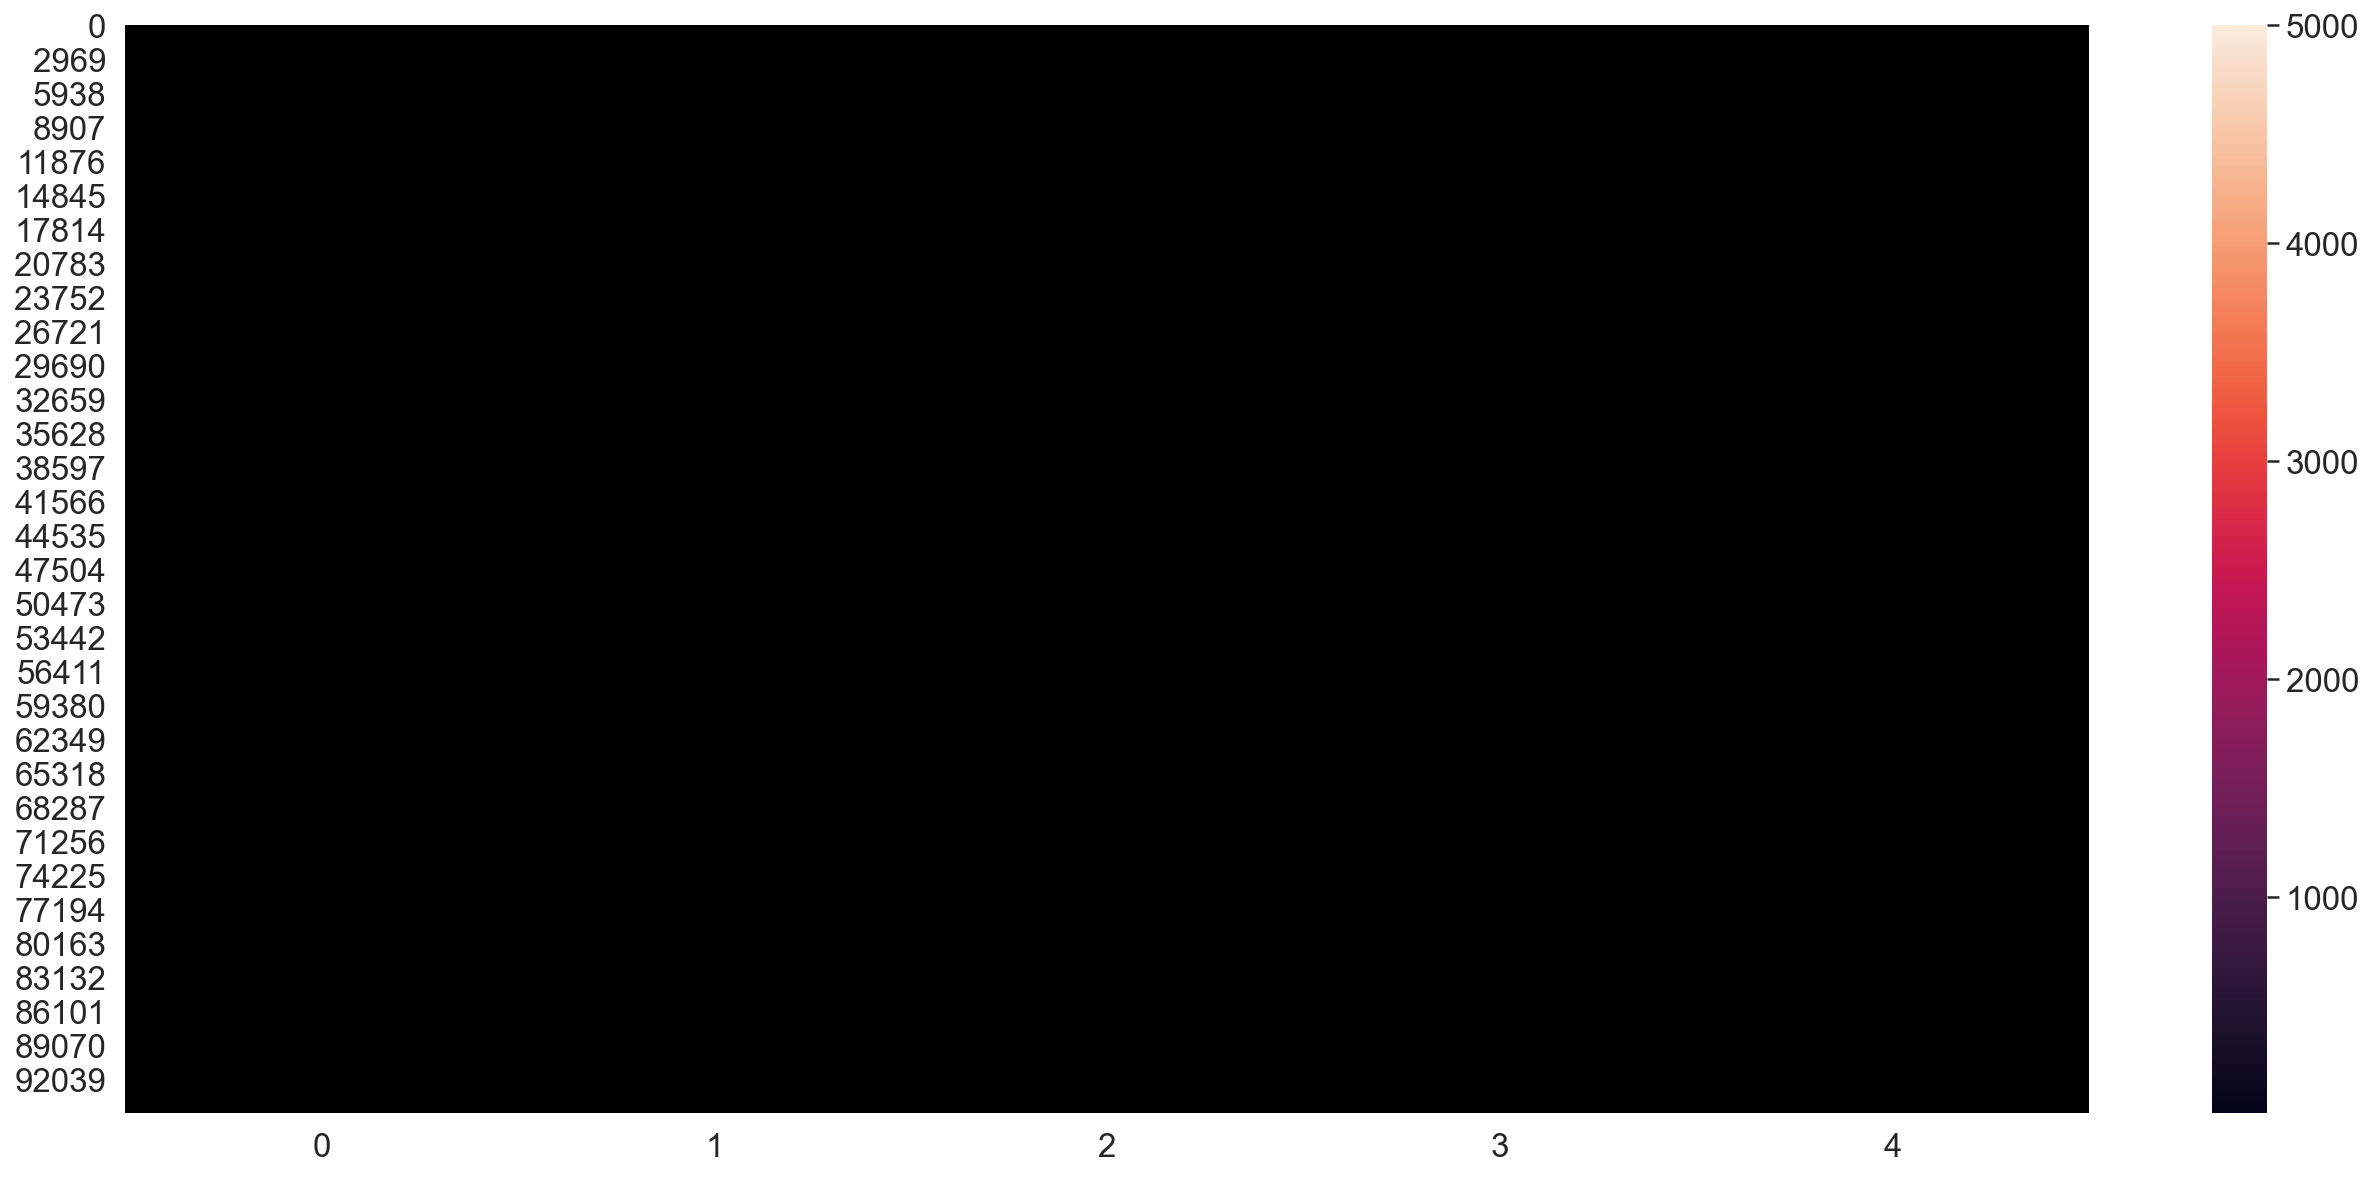

In [182]:
# Sample mar data -----------------------------------------
X_miss_mar = produce_NA(X, p_miss=0.1, mecha="MAR", p_obs=0.08)

X_mar = X_miss_mar['X_incomp']
R_mar = X_miss_mar['mask']

print("Percentage of generated missing values: ", (R_mar.sum()).numpy()/np.prod(R_mar.size())*100, " %")

ax = sns.heatmap(X_mar, mask=R_mar.numpy()==1, linewidths=0.05, linecolor='black')

tensor([[  20.2000,   58.0000,  704.0000,   32.0000, 1017.2000],
        [  20.1000,   58.0000,  689.0000,   32.0000, 1017.3000],
        [  20.1000,   58.0000,  706.0000,   32.0000, 1017.3000],
        ...,
        [  16.8000,   52.0000,  764.0000,   32.0000, 1024.8000],
        [  16.8000,   52.0000,  743.0000,   32.0000, 1024.7000],
        [  16.8000,   52.0000,  738.0000,   32.0000, 1024.7000]],
       dtype=torch.float64)

In [122]:
data.index

Int64Index([1617228022, 1617228324, 1617228626, 1617228929, 1617229232,
            1617229535, 1617229838, 1617230140, 1617230443, 1617230746,
            ...
            1646086230, 1646086532, 1646086835, 1646087138, 1646087441,
            1646087743, 1646088046, 1646088348, 1646088651, 1646088954],
           dtype='int64', name='Timestamp', length=94978)

In [94]:
data.columns

Index(['Timezone : Europe/Paris', 'Temperature', 'Humidity', 'CO2', 'Noise',
       'Pressure'],
      dtype='object')

In [191]:
df = X_mcar

In [192]:
df = df.numpy()

In [193]:
df = pd.DataFrame(data=df, columns=['Temperature', 'Humidity', 'CO2', 'Noise','Pressure'])

In [194]:
df['Timestamp']= data.index
df.set_index('Timestamp',inplace = True)

In [187]:
# EDA : describe data quickly by pandas-profiling
## !pip install pandas_profiling   ## si erreur 
from pandas_profiling import ProfileReport
profile=ProfileReport(df, title='Netatmo Air-Quality',html={'style':{'full_width':True}})

In [188]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

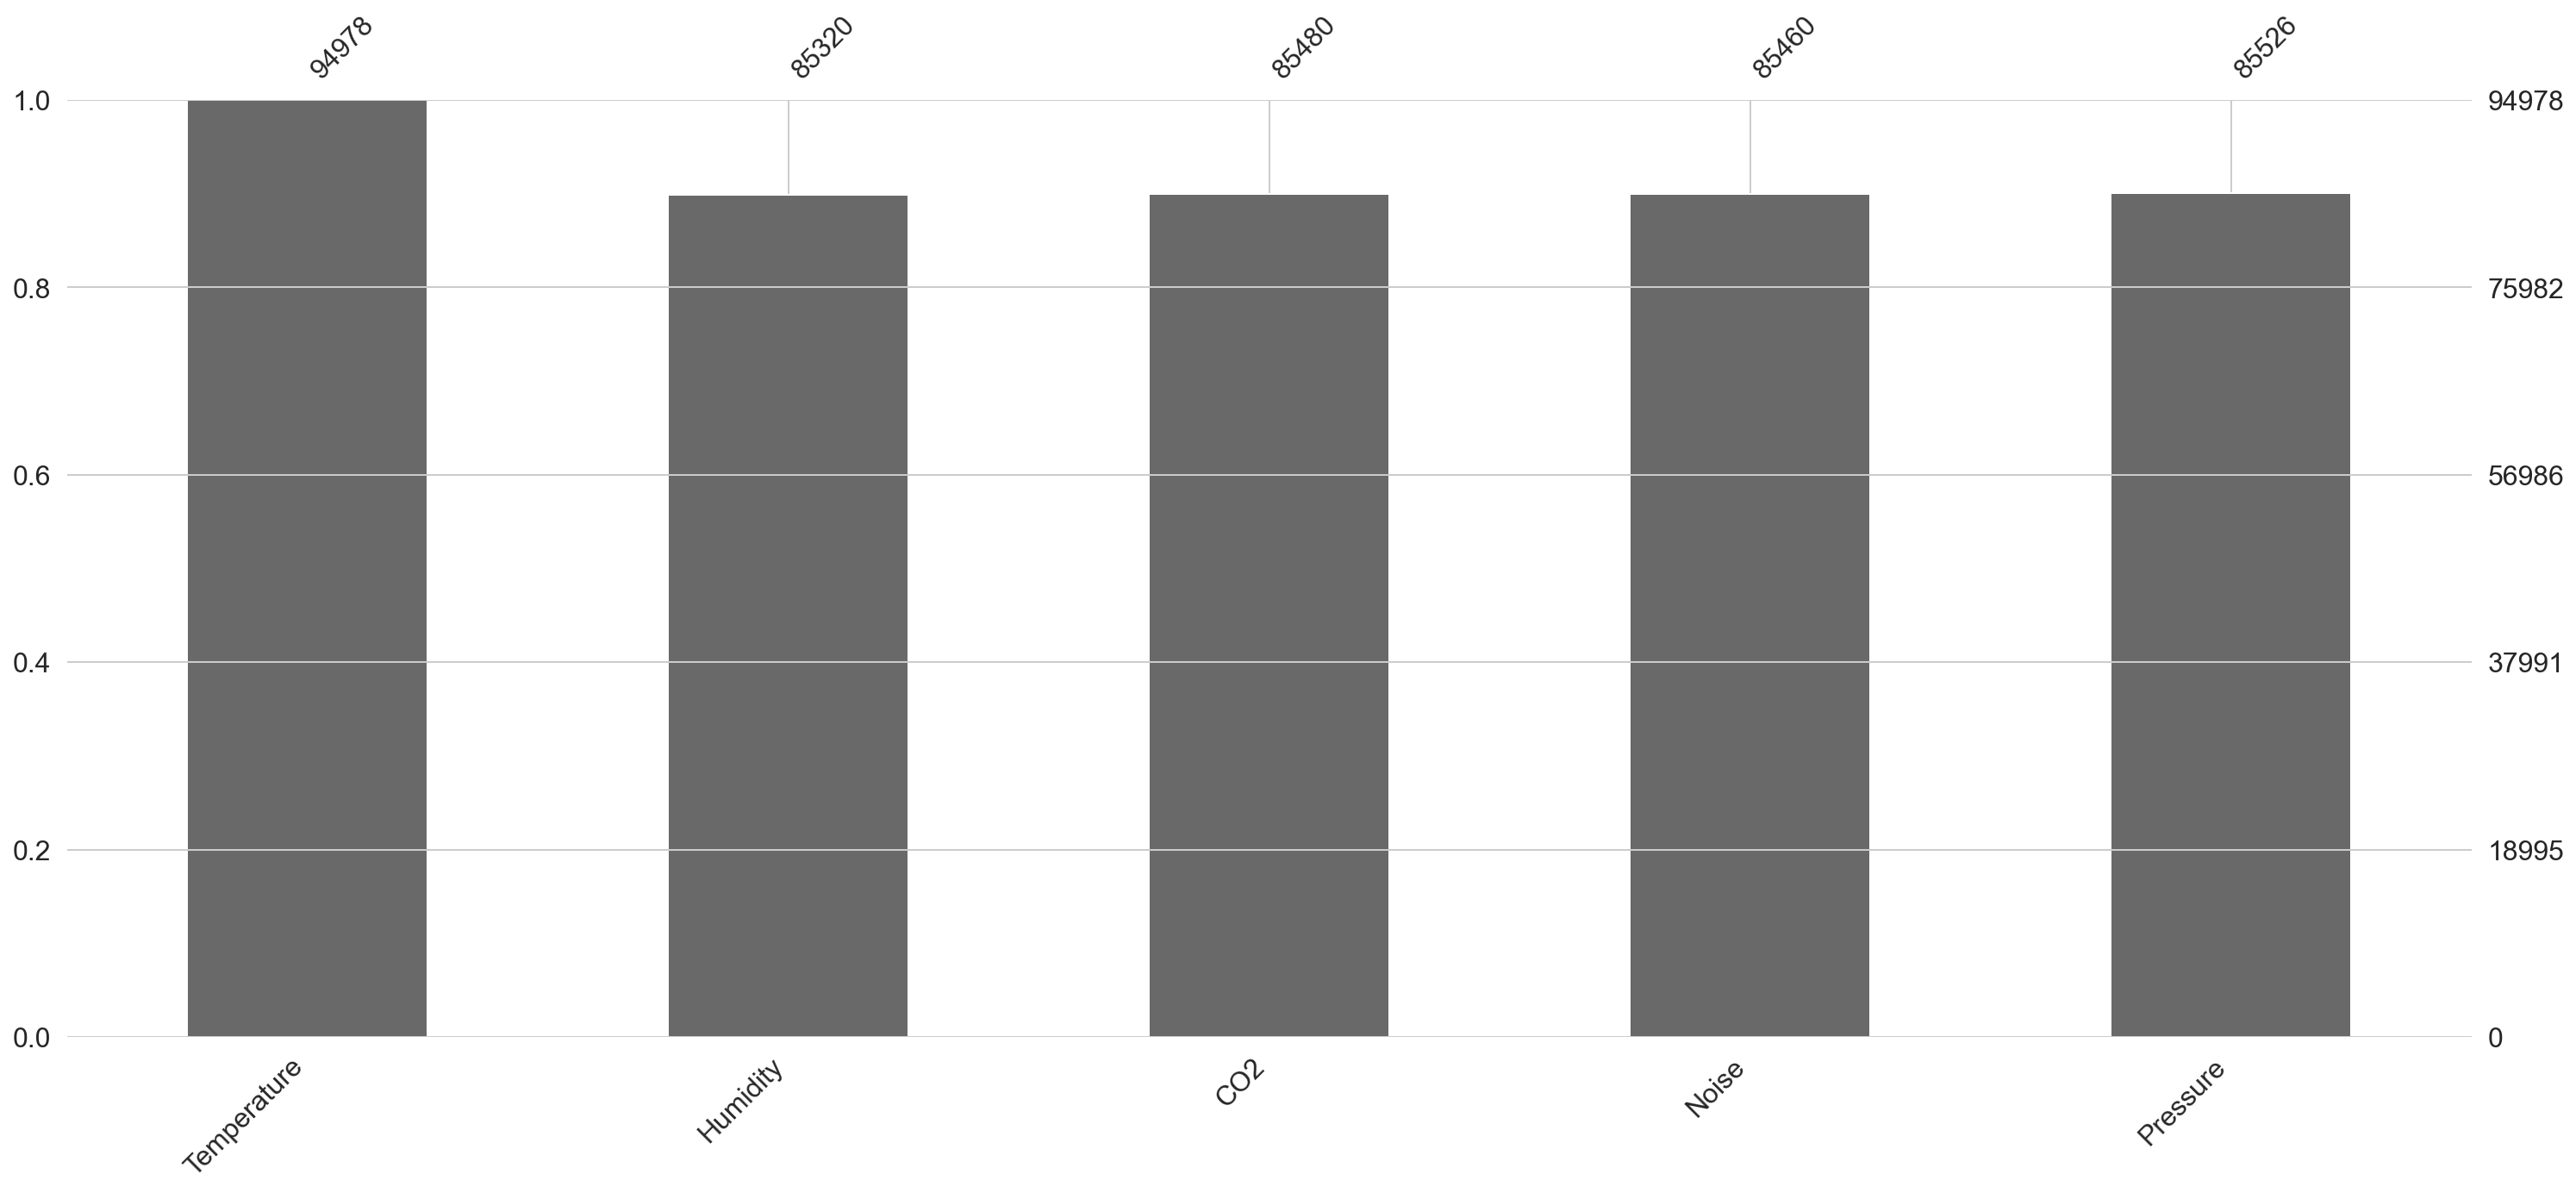

In [189]:
#visualize data 

# Import missingno as msno
import missingno as msno
import matplotlib.pyplot as plt

# Plot amount of missingness
msno.bar(df) # you can see pandas-profilin count part

plt.show()

KeyError: 'Dataframe index must be PeriodIndex or DatetimeIndex.'

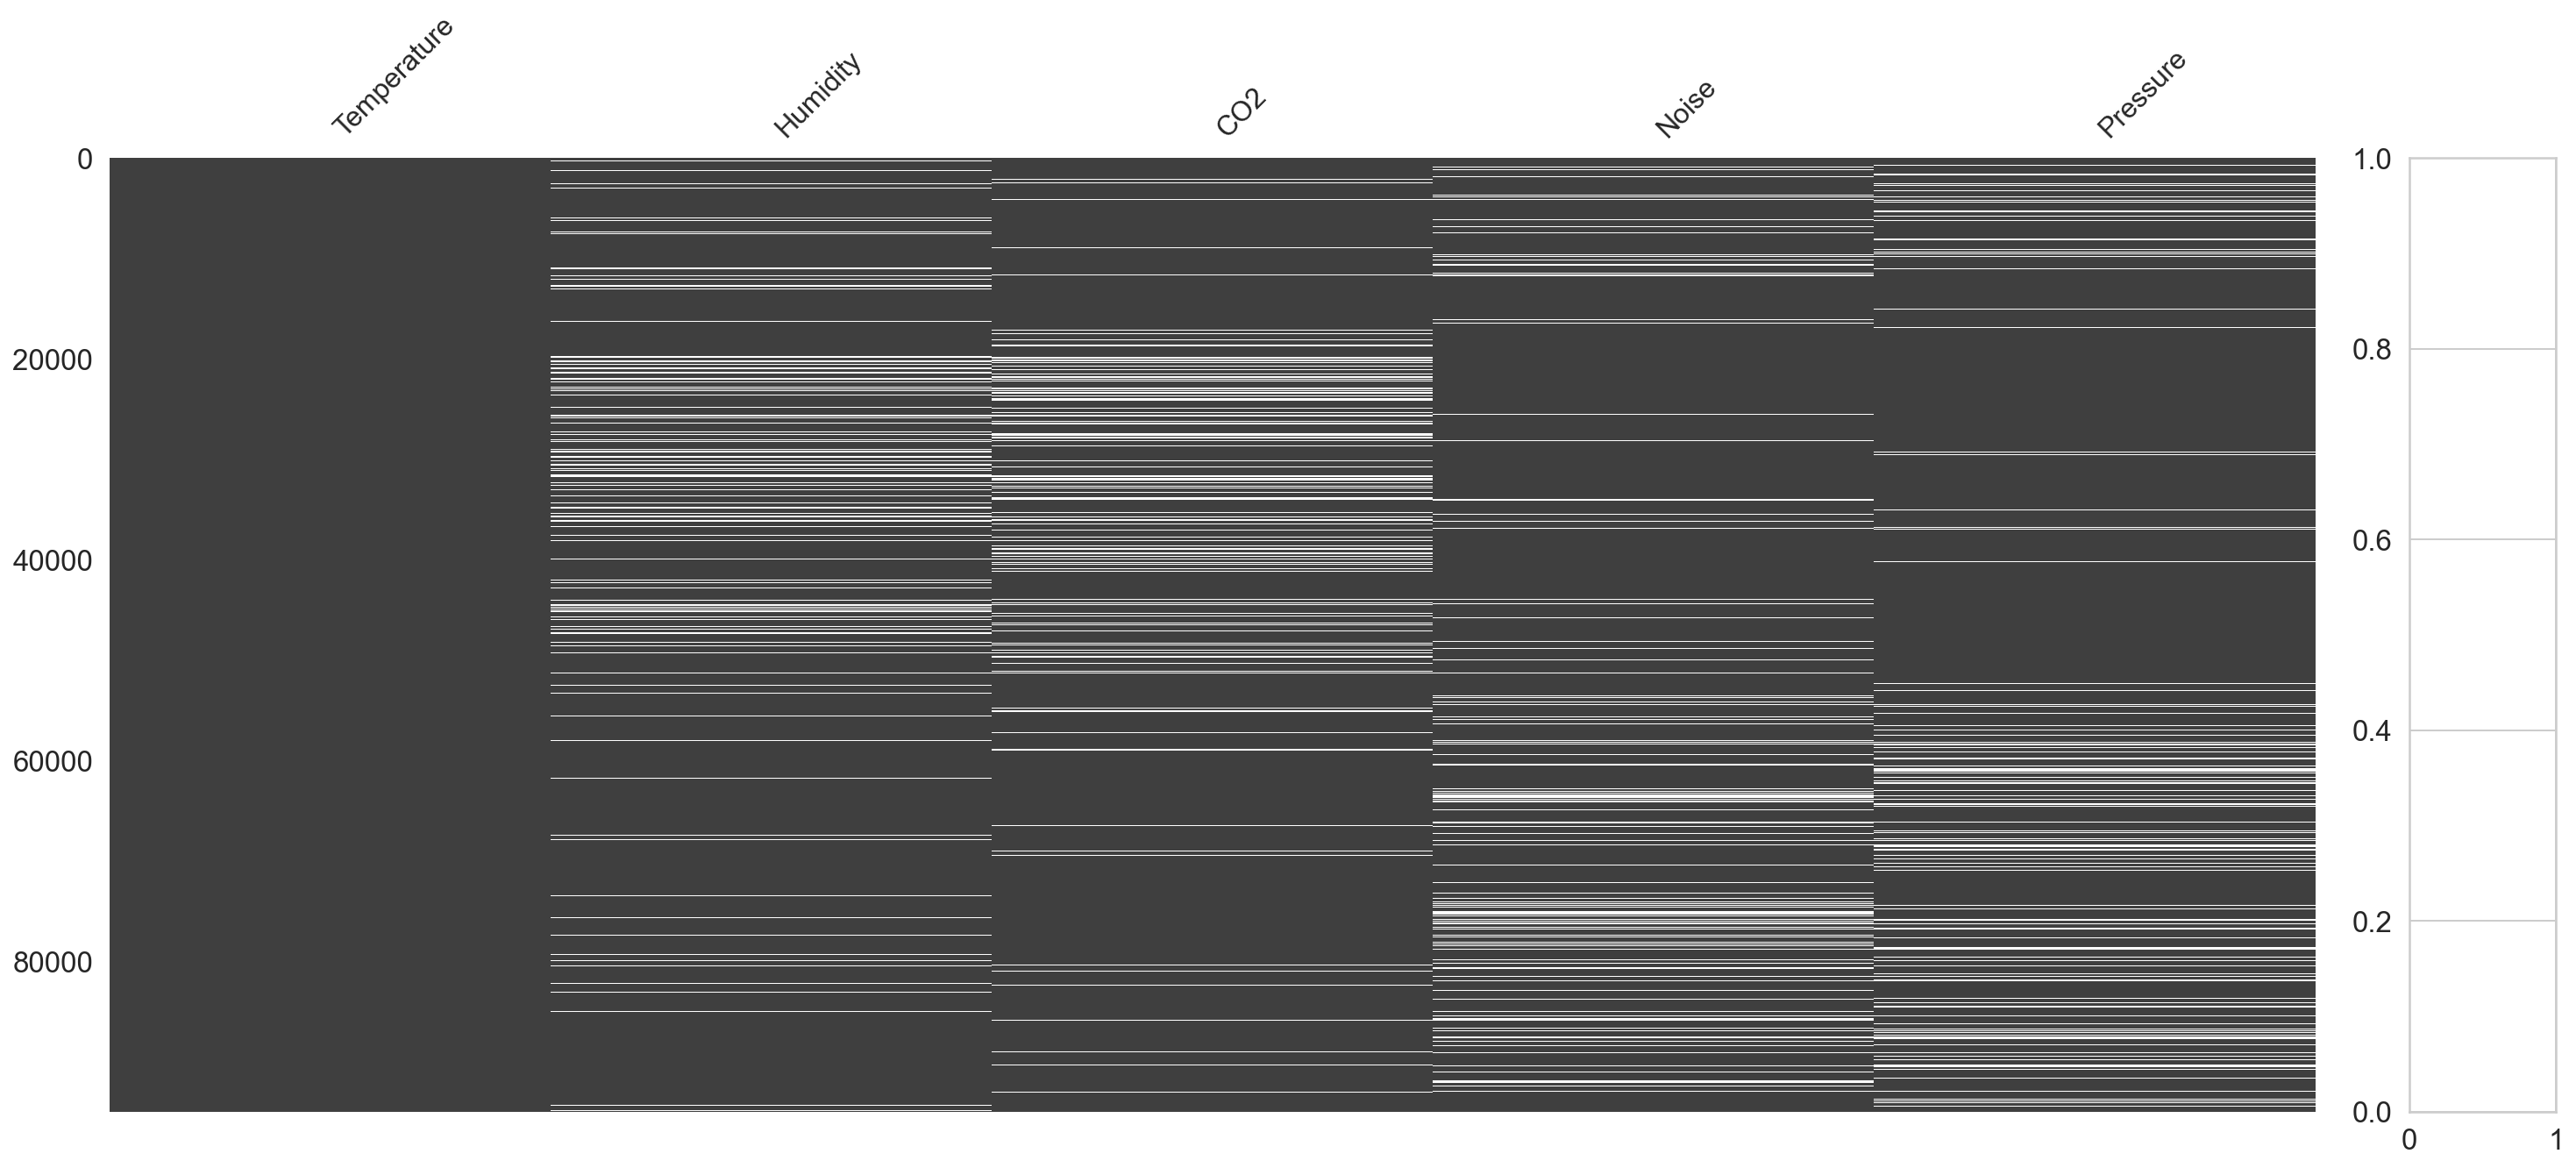

In [190]:
# Plot nullity matrix of airquality with frequency 'M'
msno.matrix(df, freq='M') # this part actually displays the missingness types, also more visible version of pandas-profiling matrix.

plt.show()

tensor([[  20.2000,       nan,       nan,       nan,       nan],
        [  20.1000,       nan,       nan,   32.0000, 1017.3000],
        [  20.1000,   58.0000,       nan,   32.0000, 1017.3000],
        ...,
        [      nan,   52.0000,       nan,       nan, 1024.8000],
        [  16.8000,       nan,  743.0000,   32.0000,       nan],
        [  16.8000,   52.0000,  738.0000,   32.0000,       nan]],
       dtype=torch.float64)

NameError: name 'mask' is not defined